In [8]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-8-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [4]:
us_national_news1 = pd.read_csv('data/mediacloud_us_national_jan_jun_2023.csv')
us_national_news2 = pd.read_csv('data/mediacloud_us_national_july_dec_2023.csv')
us_national_news = pd.concat([us_national_news1, us_national_news2], 0)
print(us_national_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31311 entries, 0 to 11232
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  31311 non-null  object
 1   article_url   31311 non-null  object
 2   id            31311 non-null  int64 
 3   language      31311 non-null  object
 4   media_name    31311 non-null  object
 5   media_url     31311 non-null  object
 6   publish_date  31311 non-null  object
 7   title         31311 non-null  object
 8   url           31311 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.4+ MB
None


<ipython-input-4-90c59128f47d>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  us_national_news = pd.concat([us_national_news1, us_national_news2], 0)


In [7]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(us_national_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 31311/31311 [00:00<00:00, 580821.70it/s]


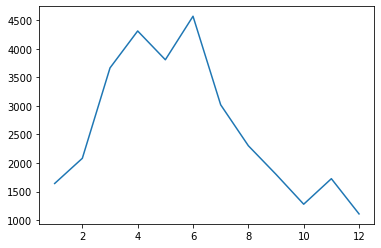

In [10]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [11]:
us_national_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
11213,en,spectator.org,http://spectator.org,2023-07-02 00:00:00,Portland Archbishop Reclaims Catholic Schools - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/portland-archbishop-reclaims-catholic-schools/
11214,en,spectator.org,http://spectator.org,2023-09-22 00:00:00,"Profiling Profitable Hoaxes: Transgenderism, Climate Change, and 19th-Century Hysteria ‘Science’ - The American Spectator | USA News and PoliticsThe American Spectator",https://spectator.org/profiling-profitable-hoaxes-transgenderism-climate-change-and-19th-century-hysteria-science/
11215,en,spectator.org,http://spectator.org,2023-07-25 00:00:00,Ron DeSantis: Next Victim of the Democrats’ Digital Reign of Terror - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/ron-desantis-next-victim-of-the-democrats-digital-reign-of-terror/
11216,en,spectator.org,http://spectator.org,2023-12-11 00:00:00,The Left’s Systemic Anti-Semitism: It Isn’t Just the UPenn President - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/the-lefts-systemic-anti-semitism-it-isnt-just-the-upenn-president/
11217,en,spectator.org,http://spectator.org,2023-07-11 00:00:00,The Lie of ‘Live and Let Live’ - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/the-lie-of-live-and-let-live-lgbtq-pride/
11218,en,spectator.org,http://spectator.org,2023-07-24 00:00:00,The Twitter Exile - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/the-twitter-exile/
11219,en,spectator.org,http://spectator.org,2023-12-26 00:00:00,The Venezuela Template Against Democracy,https://spectator.org/the-venezuela-template-against-democracy/?utm_source=rss&utm_medium=rss&utm_campaign=the-venezuela-template-against-democracy
11220,en,spectator.org,http://spectator.org,2023-11-12 00:00:00,Trans-Forming California - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/trans-forming-california/
11221,en,spectator.org,http://spectator.org,2023-08-07 00:00:00,Trans Individuals Seek Euthanasia After ‘Gender-Affirming Care’ - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/trans-individuals-seek-euthanasia-after-gender-affirming-care/
11222,en,spectator.org,http://spectator.org,2023-09-25 00:00:00,Trump Falters in the Culture War - The American Spectator | USA News and PoliticsThe American Spectator,https://spectator.org/trump-falters-in-the-culture-war/


In [14]:
relevant_news = us_national_news[us_national_news['media_name'].isin(['foxnews.com',
                                                                      'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495 entries, 5354 to 6441
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    3495 non-null   object
 1   publish_date  3495 non-null   object
 2   title         3495 non-null   object
 3   url           3495 non-null   object
dtypes: object(4)
memory usage: 136.5+ KB
None


In [15]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)#.dt.date
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495 entries, 5354 to 6441
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    3495 non-null   object        
 1   publish_date  3495 non-null   datetime64[ns]
 2   title         3495 non-null   object        
 3   url           3495 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 136.5+ KB
None


In [16]:
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495 entries, 5354 to 6441
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    3495 non-null   object        
 1   publish_date  3495 non-null   datetime64[ns]
 2   title         3495 non-null   object        
 3   url           3495 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 136.5+ KB
None


In [17]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        text = article.text
    except:
        subtitle = None
        text = None
    return subtitle, text

In [18]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

 46%|████▌     | 1599/3495 [15:51<17:03,  1.85it/s] /home/pranavgoel/miniconda3/envs/pg3/lib/python3.8/site-packages/PIL/Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
100%|██████████| 3495/3495 [38:21<00:00,  1.52it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495 entries, 5354 to 6441
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    3495 non-null   object        
 1   publish_date  3495 non-null   datetime64[ns]
 2   title         3495 non-null   object        
 3   url           3495 non-null   object        
 4   subtitle      3488 non-null   object        
 5   text          3488 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 191.1+ KB
None


In [19]:
relevant_news['media_name'].value_counts()

foxnews.com    2339
nytimes.com    1156
Name: media_name, dtype: int64

In [20]:
subtitles_with_null, texts_with_null = [], []
for s in subtitles:
    if s == '' or s == ' ':
        subtitles_with_null.append(None)
    else:
        subtitles_with_null.append(s)
for t in texts:
    if t == '' or t == ' ':
        texts_with_null.append(None)
    else:
        texts_with_null.append(t)
relevant_news['subtitle'] = subtitles_with_null
relevant_news['text'] = texts_with_null
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495 entries, 5354 to 6441
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    3495 non-null   object        
 1   publish_date  3495 non-null   datetime64[ns]
 2   title         3495 non-null   object        
 3   url           3495 non-null   object        
 4   subtitle      3268 non-null   object        
 5   text          3479 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 191.1+ KB
None


In [21]:
relevant_news.to_csv('data/nytimes_foxnews_article_texts_and_info.csv',
                     index=False)